# Importing libraries

In [3]:
import numpy as np
import pandas as pd
#pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
!pip install wordcloud
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image
library(readr)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


#  train and test files sfrom urls


In [10]:
test_file="https://raw.githubusercontent.com/bhumika26/Box-Office-Data-Analysis/master/data/test.csv"
train_file="https://raw.githubusercontent.com/bhumika26/Box-Office-Data-Analysis/master/data/train.csv"
test=pd.read_csv(test_file)
train=pd.read_csv(train_file)

In [11]:
train.head()


,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,...,12,4,2,13,8,4,2,4,4,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,...,0,0,1,0,1,1,1,0,0,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,10/10/14,...,5,9,1,5,4,3,6,3,1,0
3,4,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,3/9/12,...,0,0,1,0,0,1,0,0,0,0
4,5,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,2/5/09,...,0,0,1,0,0,1,0,0,0,0


# visualizing target distribution

C:\Users\pavan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



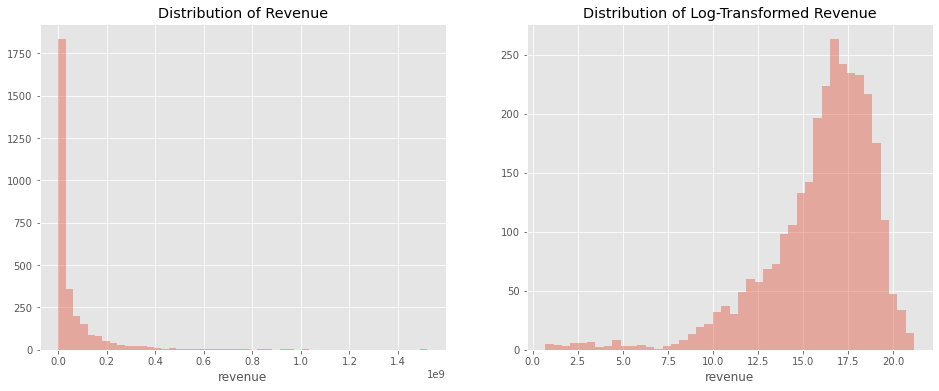

In [12]:
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.distplot(train['revenue'],kde=False);
plt.title('Distribution of Revenue');
plt.subplot(1,2,2)
sns.distplot(np.log1p(train['revenue']),kde=False);
plt.title('Distribution of Log-Transformed Revenue');

In [13]:
train['log-revenue']=np.log1p(train['revenue'])

# Relationship between Film Revenue and Budget

C:\Users\pavan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\pavan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Log revenue vs Log Budget')

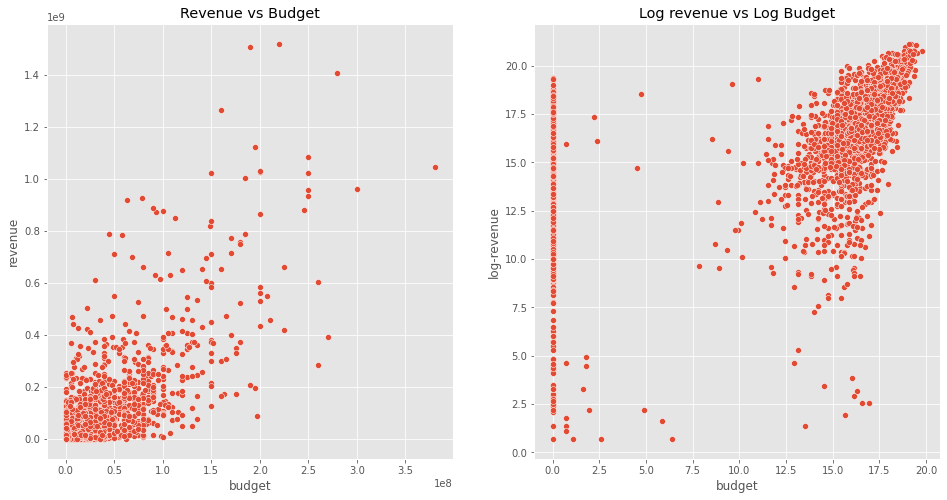

In [14]:
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
sns.scatterplot(train['budget'],train['revenue'])
plt.title('Revenue vs Budget')
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(train['budget']),train['log-revenue'])
plt.title('Log revenue vs Log Budget')

In [15]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

# Does having an Official Homepage Affect Revenue?

In [16]:
train['homepage'].value_counts().head(10)

http://www.transformersmovie.com/                      4
http://www.thehobbit.com/                              2
http://www.lordoftherings.net/                         2
http://sonyclassics.com/whiplash/                      1
https://www.facebook.com/thefinesthoursmovie           1
http://sonyclassics.com/pariscanwait/                  1
http://www.maxpaynethemovie.com                        1
http://www.sonypictures.com/movies/afewgoodmen/        1
http://www.theasylum.cc/product.php?id=203             1
http://www.miramax.com/movie/the-cider-house-rules/    1
Name: homepage, dtype: int64

Text(0.5, 1.0, 'Revenue for Films With & Withhout Homepage')

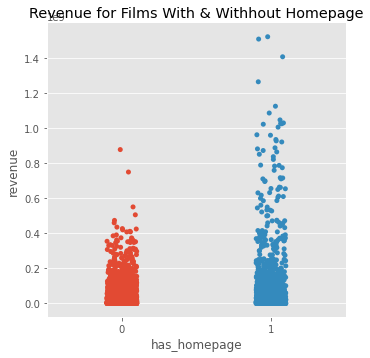

In [17]:
train['has_homepage']=0
train.loc[train['homepage'].isnull()== False,'has_homepage']=1
test['has_homepage']= 0
test.loc[test['homepage'].isnull()== False,'has_homepage']=1
sns.catplot(x='has_homepage', y ='revenue', data =train)
plt.title('Revenue for Films With & Withhout Homepage')

# Distribution of Languages in Film

Text(0.5, 1.0, 'Mean log revenue per language')

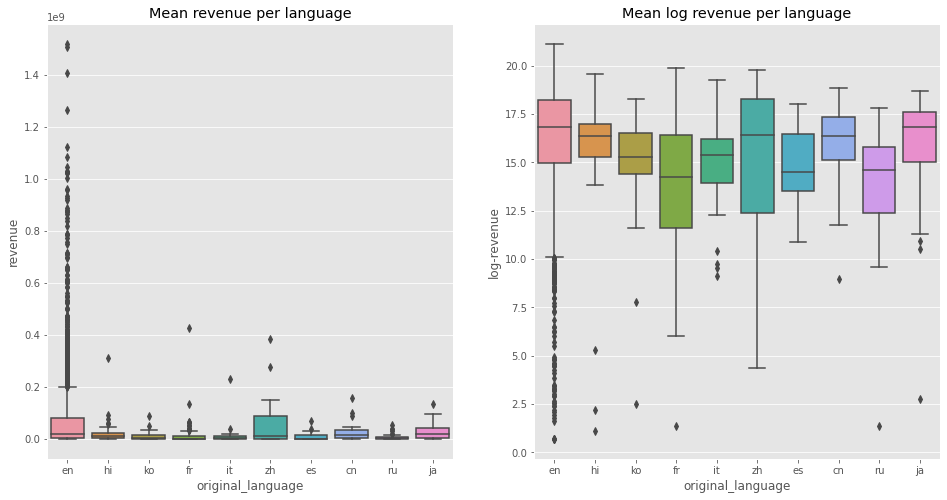

In [18]:
language_data = train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue',data=language_data)
plt.title('Mean revenue per language')
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log-revenue',data=language_data)
plt.title('Mean log revenue per language')

# Do Film Descriptions Impact Revenue?


In [23]:
!pip install eli5
import eli5
from sklearn.linear_model import LinearRegression

  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=22ec47ce8060c7f41d943b5c391f2d26fff506fba0ad1b291615ab91b9540c7c
  Stored in directory: c:\users\pavan\appdata\local\pip\cache\wheels\7b\26\a5\8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.2 which is incompatible.


In [24]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    min_df=5
)
overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log-revenue'])
eli5.show_weights(linreg,vec=vectorizer, top=20, feature_filter=lambda x: x!='<BIAS>')

C:\Users\pavan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [41]:
print('Target value:', train['log-revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

Target value: 16.44583954907521


C:\Users\pavan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [28]:
test.loc[test['release_date'].isnull()== False, 'release_date'].head(10)

0     7/14/07
1     5/19/58
2     5/23/97
3      9/4/10
4     2/11/05
5      2/7/96
6    12/23/10
7     2/11/00
8      3/2/07
9    10/30/99
Name: release_date, dtype: object

In [29]:
def fix_date(x):
  year = x.split('/')[2]
  if int(year) <= 19:
    return x[:-2] + '20' + year
  else:
    return x[:-2] + '19' + year
     

In [30]:
test.loc[test['release_date'].isnull()== True].head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors,log_budget,has_homepage
828,3829,0,NaN,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,0


In [31]:
test.loc[test['release_date'].isnull()== True, 'release_date'] = '05/01/00'
# fixing the missing value of the release_date column

In [32]:
train['release_date'] = train['release_date'].apply(lambda x : fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x : fix_date(x))

In [33]:
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [34]:
# feature engineering the release dates
def process_date (df) :
  date_parts = ['year', 'month', 'weekday', 'weekofyear', 'day', 'quarter']
  for part in date_parts:
    part_col = 'release_date' + '_' + part
    df[part_col] = getattr(df['release_date'].dt, part).astype(int)
  return df

train = process_date(train)
test = process_date(test)

C:\Users\pavan\AppData\Local\Temp\ipykernel_9556\320277757.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

C:\Users\pavan\AppData\Local\Temp\ipykernel_9556\320277757.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [35]:
import plotly
# print(plotly.__version__)

In [36]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# x values are years and y values are movie counts, name= legend
data = [go.Scatter(x=d1.index, y=d1.values, name='train'),
        go.Scatter(x=d2.index, y=d2.values, name='test')]

layout = go.Layout(dict(title="Number of films per year",
                        xaxis=dict(title='Year'),
                        yaxis=dict(title='Count'),
                       ), legend=dict(orientation='v'))
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")


In [37]:

# Number of Films and Revenue generated

d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'),
        go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]

layout = go.Layout(dict(title = "Number of films and total revenue per year",
                        xaxis = dict(title = 'Year'),
                        yaxis = dict(title = 'Count'),
                        yaxis2 = dict(title='Total revenue', overlaying='y', side='right')),
                   legend=dict(orientation="v"))

fig = go.Figure(data=data, layout=layout)
fig.show(renderer = "colab")
     

In [38]:
# Number of Films and Average Revenue
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'),
        go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]

layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
fig = go.Figure(data=data, layout=layout)
fig.show(renderer = "colab")

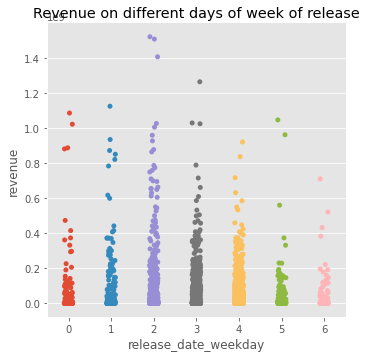

In [42]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');
     

C:\Users\pavan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\pavan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



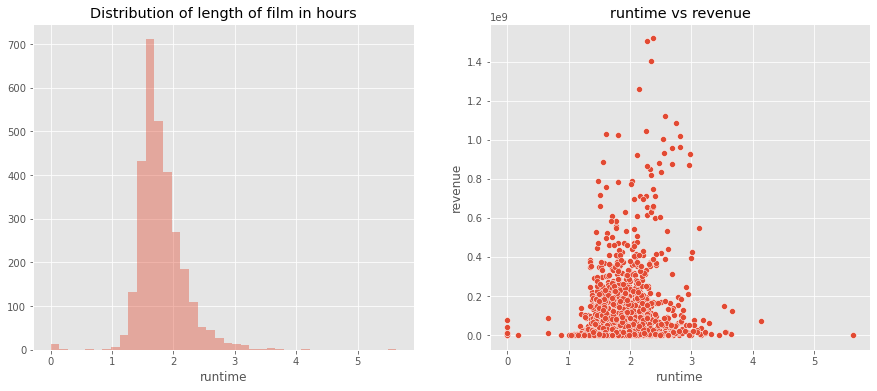

In [43]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.distplot(train['runtime'].fillna(0) / 60, bins=40, kde=False);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 2, 2)
sns.scatterplot(train['runtime'].fillna(0)/60, train['revenue'])
plt.title('runtime vs revenue');

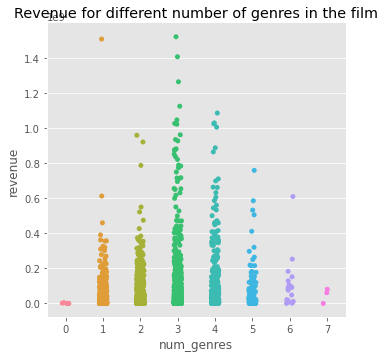

In [44]:
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');